## BRANDS AND PRODUCTS EMOTIONS 


**Business Problem:**

In an era dominated by social media, brands must continuously track customer sentiments expressed online. Twitter, in particular, has become a critical platform where users voice their opinions about products and brands. However, the vast volume and rapid pace of tweets make it impractical for businesses to manually analyze these opinions for insights. To address this, a Natural Language Processing (NLP) model needs to be developed to automatically classify the sentiment of tweets and determine which brand or product is the target of those sentiments.

The dataset from CrowdFlower includes over 9,000 tweets that have been evaluated for sentiment (positive, negative, or no emotion) and tagged with the associated brand or product. The goal is to build an NLP model that can accurately and efficiently:

1. **Classify Sentiments**: Identify whether a tweet expresses positive, negative, or no emotion.
2. **Identify Brand/Product**: Recognize which brand or product is being referred to in the tweet.
3. **Handle Ambiguity**: Deal with tweets that might reference multiple brands or unclear sentiments.

Key challenges include:

- **Textual Variations**: Dealing with informal language, abbreviations, emojis, and slang used on social media.
- **Context Understanding**: Ensuring the model understands subtle and implicit expressions of sentiment.
- **Real-Time Processing**: Building a scalable solution that can process large volumes of data in real time for timely insights.

Solving this problem will help brands enhance their reputation management, respond promptly to consumer feedback, and optimize their marketing strategies based on real-time sentiment analysis.



## Overview:


**Data Understanding:**

The dataset provided contains 9,093 rows of tweet evaluations, focusing on tweets mentioning various brands and products. The data was crowdsourced, with contributors being asked to assess whether a tweet conveyed positive, negative, or no emotion towards a brand or product. If an emotion was expressed, the contributors were further asked to identify the specific brand or product being referred to.

### Key Features of the Data:
1. **Tweet Text**: This contains the actual text of the tweet, which is the main input for sentiment analysis and brand/product identification.
2. **Emotion Label**: Indicates whether the tweet expresses:
   - Positive sentiment
   - Negative sentiment
   - No sentiment (neutral)
3. **Brand/Product Label**: Identifies the brand or product that is the subject of the expressed emotion (if applicable). Some tweets may not reference a brand/product, especially those classified as neutral.
4. **Contributor Annotations**: Information about how the tweet was classified by different crowd contributors, which might provide insights into the subjectivity of sentiment classification.

### Data Considerations:
- **Textual Noise**: As the dataset is composed of tweets, the text may contain slang, abbreviations, misspellings, and non-standard grammar typical of social media posts. Tweets may also include emojis and special characters, which need to be handled properly during data preprocessing.
- **Imbalanced Sentiment Distribution**: There may be a natural imbalance in the data, with more tweets being neutral or expressing positive emotions than negative ones. This imbalance could affect the performance of a sentiment classifier and should be considered during model training.
- **Ambiguous Sentiments**: Some tweets may contain conflicting signals, such as sarcasm or mixed emotions, making it difficult to assign a clear sentiment. The crowdsource annotations may reflect this ambiguity in some cases.
- **Multilabel Outputs**: A single tweet could reference multiple brands or products. The model needs to account for the possibility of multiple correct labels for brand/product identification.
- **Contributor Discrepancies**: Since sentiment is subjective, different contributors may have classified the same tweet differently. Understanding and resolving these discrepancies will be crucial to ensure the accuracy of the model’s training data.

### Data Exploration Goals:
1. **Sentiment Distribution**: Examine the distribution of positive, negative, and neutral tweets to understand the balance of sentiments in the data.
2. **Brand/Product Mentions**: Explore how many distinct brands or products are mentioned and the frequency of mentions for each brand or product.
3. **Textual Characteristics**: Investigate the average length of tweets, frequency of common words, use of emojis, and presence of hashtags or mentions. This will help tailor preprocessing steps.
4. **Annotator Agreement**: Check how often annotators agreed on the sentiment or brand/product for each tweet, as this might highlight instances of ambiguity or disagreement.

By understanding the structure and challenges of the data, we can ensure that the subsequent steps in the NLP model development process, such as preprocessing, feature engineering, and model selection, are tailored to the characteristics of the dataset.


**Data source:** https://data.world/crowdflower/brands-and-product-emotions

# Step 1: import necessary libraries

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import RegexpTokenizer, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

from sklearn.model_selection import train_test_split, cross_validate
from numpy import array
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# TensorFlow and Keras imports using tensorflow.keras namespace
from tensorflow import keras
from tensorflow.keras import regularizers, layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, Embedding

import nltk
nltk.download('punkt')  # Download the tokenizer data
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ronoe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [47]:
#load the dataset
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding = 'unicode_escape')
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [49]:
# Let us change our our names for easier reading, the columns are so long./
df = df.rename(columns={
    'tweet_text': 'Tweet',
    'emotion_in_tweet_is_directed_at': 'Product',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'Sentiment'
})

# Display the renamed DataFrame to verify the changes
print(df.head())

                                               Tweet             Product  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone   
1  @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2  @swonderlin Can not wait for #iPad 2 also. The...                iPad   
3  @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...              Google   

          Sentiment  
0  Negative emotion  
1  Positive emotion  
2  Positive emotion  
3  Negative emotion  
4  Positive emotion  


In [50]:

#looking at data, duplicates and null valuesprint
def data_summary(df):
    # Print the DataFrame info
    print(df.info())
    print(("-" * 20))
    
    # Print the total number of duplicated rows
    print('Total duplicated rows')
    print(df.duplicated().sum())
    print(("-" * 20))
    
    # Print the total number of null values in each column
    print('Total null values')
    print(df.isna().sum())
data_summary(df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      9092 non-null   object
 1   Product    3291 non-null   object
 2   Sentiment  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB
None
--------------------
Total duplicated rows
22
--------------------
Total null values
Tweet           1
Product      5802
Sentiment       0
dtype: int64


In [51]:
#sentiment breakdown
df['Sentiment'].value_counts() 

Sentiment
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

The value counts in the sentiment columns has four value counts with the highest being No emotion towards a brand or product having 5389. the lowest is i can't tell with 156. Both positve and Negative have 2978 and 570 respetively.

we will simplify the sentiment column to be either positive, no emotion/neutral or negative

In [52]:
#Simplify sentiment labels for visualizations
dict_sent = {'No emotion toward brand or product':"No emotion", 
             'Positive emotion':'Positive emotion',
             'Negative emotion':'Negative emotion',
             "I can't tell": "I can't tell"}
df['Sentiment'] = df['Sentiment'].map(dict_sent)

In [53]:
#sentiment breakdown
df['Sentiment'].value_counts() 

Sentiment
No emotion          5389
Positive emotion    2978
Negative emotion     570
I can't tell         156
Name: count, dtype: int64

In [54]:
df['Product'].value_counts()


Product
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

In [55]:
# drop the Nan in the Tweet column
df['Tweet'].dropna(inplace=True)
df

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion
9091,Some Verizon iPhone customers complained their...,NaN,No emotion


In [56]:
# we drop the duplicates
df.drop_duplicates(inplace=True)
df

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion
9091,Some Verizon iPhone customers complained their...,NaN,No emotion


In [57]:
#drops Tweets with nonsensical characters
df.drop([6, 9092], inplace=True)

In [58]:
#reset the index after cleaning
df.reset_index(inplace=True)
df.drop(columns="index", inplace = True)
#looks at cleaned dataframe
df

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9064,"@mention Yup, but I don't have a third app yet...",NaN,No emotion
9065,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9066,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion
9067,"Google's Zeiger, a physician never reported po...",NaN,No emotion


In [59]:
#looks at remaining NaN's
print(df.isna().sum())


Tweet           0
Product      5787
Sentiment       0
dtype: int64


In [60]:
#Fills NaN's with "Undefined" to help with data visualizations
df['Product'].fillna("Undefined", inplace = True)
df

C:\Users\ronoe\AppData\Local\Temp\ipykernel_712\1728240075.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Product'].fillna("Undefined", inplace = True)


,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9064,"@mention Yup, but I don't have a third app yet...",Undefined,No emotion
9065,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9066,"Wave, buzz... RT @mention We interrupt your re...",Undefined,No emotion
9067,"Google's Zeiger, a physician never reported po...",Undefined,No emotion


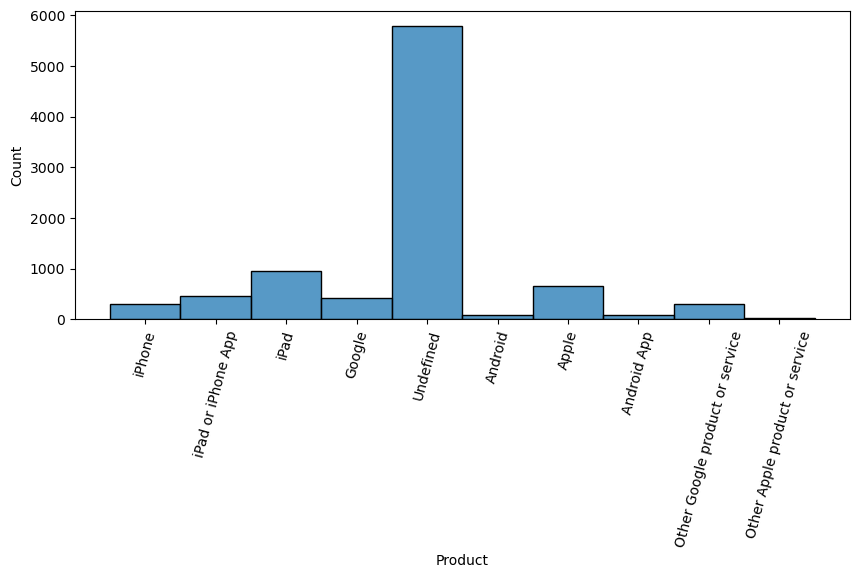

In [61]:
fig, ax = plt.subplots(figsize=(10,4))
sns.histplot(df["Product"] )
plt.xticks(rotation = 75)
plt.show()

There is a large imbalance between the undetermined products this may hinder analysis of product sentiment, however we can use this column to help us describe which brand the tweets are focused on.

In [62]:
#we are going to set the Product type as a string for our function below.
df["Product"].astype(str)

0                   iPhone
1       iPad or iPhone App
2                     iPad
3       iPad or iPhone App
4                   Google
               ...        
9064             Undefined
9065                  iPad
9066             Undefined
9067             Undefined
9068             Undefined
Name: Product, Length: 9069, dtype: object

The model is being built to gauge a brand's sentiment. Therefore we must look at a break down of different companies with in the dataset. The two brands in this data set happen to be two of the biggest tech brands in the world. Apple and Google. So we will create a new column to designate each tweet to a brand.

In [63]:
def find_brand(Product, Tweet):
    """
    This function is designed to take build a brand column based on the Product description. 
    After, the function will look at the Tweets and determine a brand for rows with no brand determined.
    
    Product -  a column teh function is working on
    Tweet - a column teh function is working on
    """
    brand = 'Undetermined' #Labeling brand as Undetermined
    if ((Product.lower().__contains__('google')) or (Product.lower().__contains__('android'))): #Labeling Google
        brand = 'Google' #Unless tweet contains google or android
    elif ((Product.lower().__contains__('apple')) or (Product.lower().__contains__('ip'))): #Labeling Apple
        brand = 'Apple' #Unless tweet contains apple or ip
    
    if (brand == 'Undetermined'): 
        lower_tweet = Tweet.lower() #Making tweet lowercase
        is_google = (lower_tweet.__contains__('google')) or (lower_tweet.__contains__('android')) #Undetermined google
        is_apple = (lower_tweet.__contains__('apple')) or (lower_tweet.__contains__('ip')) #Undetermined apple
        
        if (is_google and is_apple): #if it has both identifiers in the tweet
            brand = 'Both' #Labeling brand as both
        elif (is_google):
            brand = 'Google' #Labeling brand as Google
        elif (is_apple):
            brand = 'Apple' #Labeling brand as Apple
    
    return brand

df['Brand'] = df.apply(lambda x: find_brand(x['Product'], x['Tweet']), axis = 1) #Applying function to column
df['Brand'].value_counts() #Reviewing value counts of each class within brand

Brand
Apple           5361
Google          2756
Undetermined     739
Both             213
Name: count, dtype: int64

**Visualization**

In [64]:
df

,Tweet,Product,Sentiment,Brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google
...,...,...,...,...
9064,"@mention Yup, but I don't have a third app yet...",Undefined,No emotion,Google
9065,Ipad everywhere. #SXSW {link},iPad,Positive emotion,Apple
9066,"Wave, buzz... RT @mention We interrupt your re...",Undefined,No emotion,Google
9067,"Google's Zeiger, a physician never reported po...",Undefined,No emotion,Google


In [65]:
def countplot(df, col, hue=None, rotation=None):
    """
    This function builds a Seaborn countplot and allows the user to set certain parameters to customize the graph.
    
    df - dataframe being used
    col- column in dataframe being used
    hue - second column being used (optional)
    rotation - sets the rotation of the x-ticks for readability
    """
    fig, ax = plt.subplots(figsize=(12,8))
    
    # Create countplot with optional hue
    sns.countplot(data=df, x=col, hue=hue, order=df[col].value_counts().index, ax=ax)
    
    # Adjust x-tick labels
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=rotation, fontsize=15)
    
    # Set axis labels
    ax.set_xlabel(xlabel=col, fontsize=20)
    ax.set_ylabel(ylabel="Number of Tweets", fontsize=20)
    
    # Set title based on whether hue is used
    if hue:
        ax.set_title(f"Number of Tweets per {col} (hue: {hue})", fontsize=30)
    else:
        ax.set_title(f"Number of Tweets per {col}", fontsize=30)
    
    # Adjust y-axis tick parameters
    ax.tick_params(axis='y', which='major', labelsize=15)
    
    plt.show()


C:\Users\ronoe\AppData\Local\Temp\ipykernel_712\1887058172.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=rotation, fontsize=15)


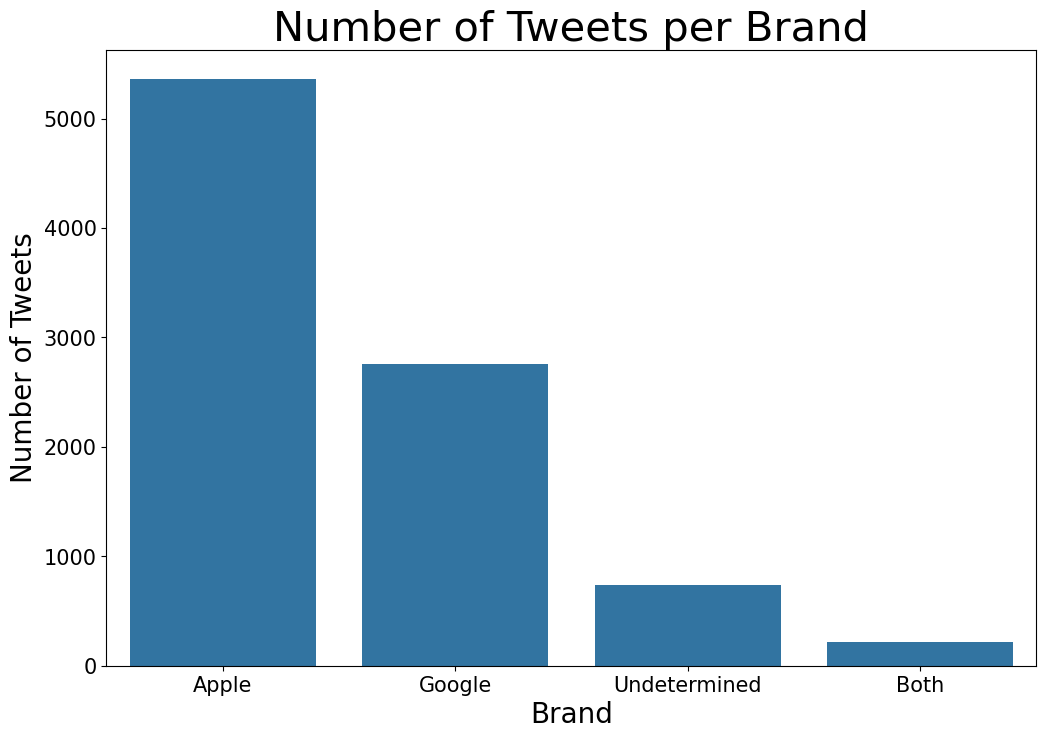

In [66]:
#countplot for Brand
countplot(df, "Brand")

C:\Users\ronoe\AppData\Local\Temp\ipykernel_712\1887058172.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=rotation, fontsize=15)


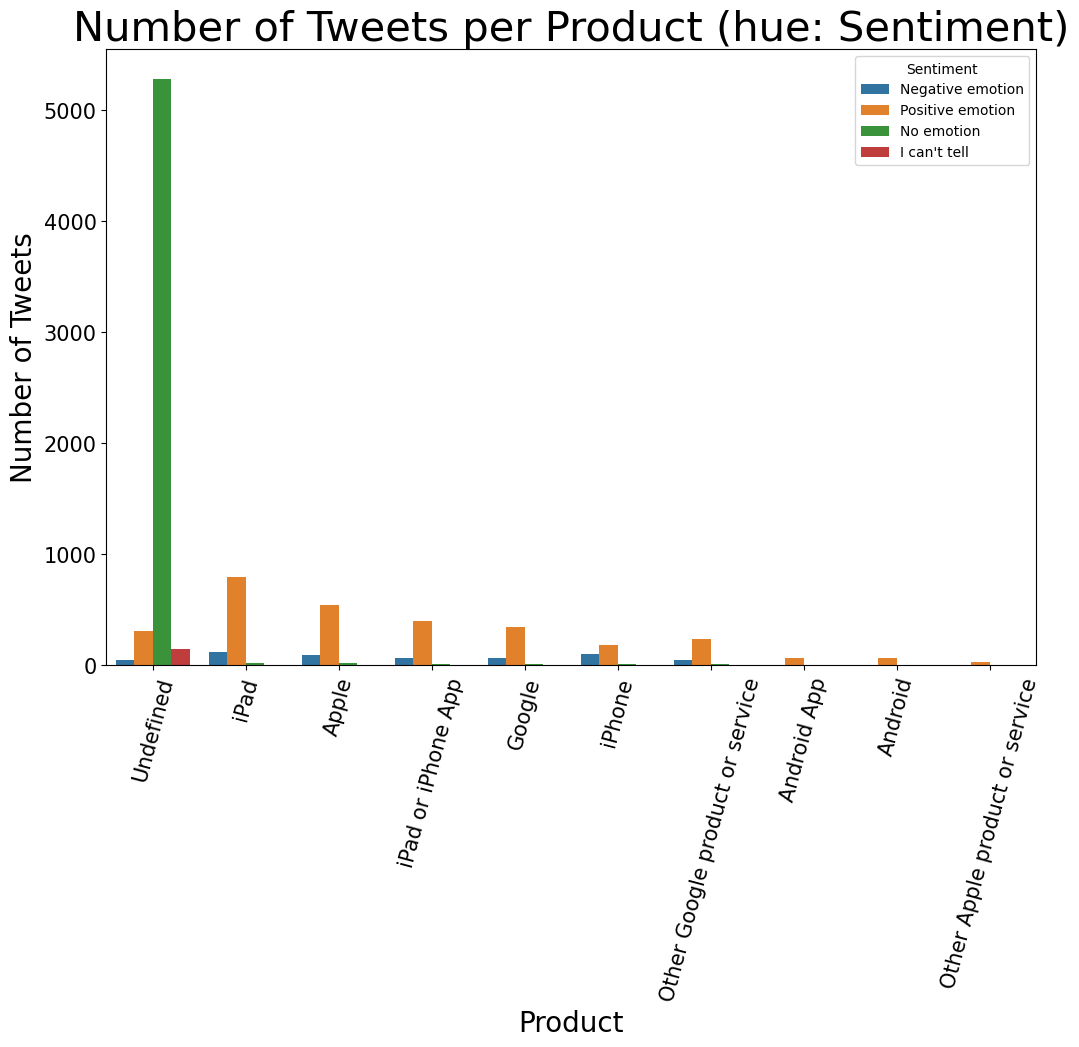

In [67]:
#countplot for Product
countplot(df, 'Product', hue='Sentiment', rotation=75)


C:\Users\ronoe\AppData\Local\Temp\ipykernel_712\1887058172.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=rotation, fontsize=15)


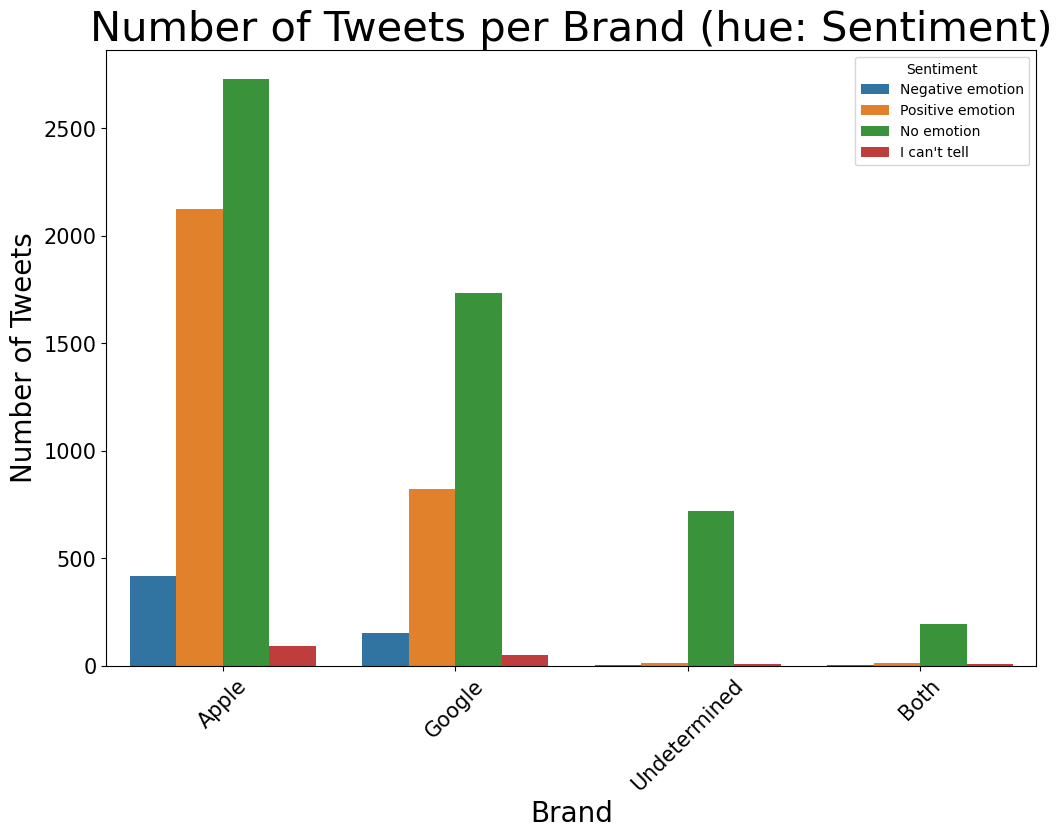

In [68]:
# Count plot for sentiment
countplot(df, col='Brand', hue='Sentiment', rotation=45)


C:\Users\ronoe\AppData\Local\Temp\ipykernel_712\1887058172.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=rotation, fontsize=15)


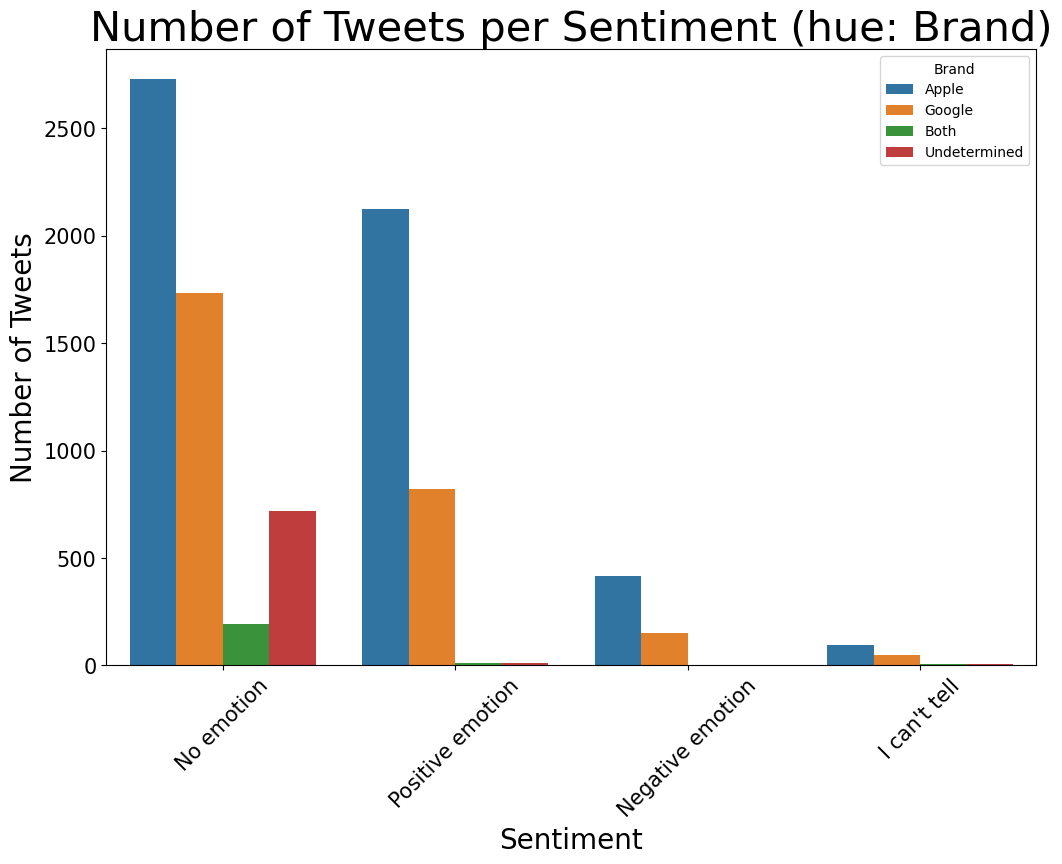

In [69]:
# countplot for Brand make of sentiment
countplot(df, col='Sentiment', hue='Brand', rotation=45)


* Lets have a look at the no of tweets per brand per sentiments.

In [70]:
grouped = df.groupby(["Brand", "Sentiment"]).count()
grouped

Tweet  Product
Brand        Sentiment                       
Apple        I can't tell         93       93
             Negative emotion    415      415
             No emotion         2730     2730
             Positive emotion   2123     2123
Both         I can't tell          7        7
             Negative emotion      3        3
             No emotion          192      192
             Positive emotion     11       11
Google       I can't tell         50       50
             Negative emotion    150      150
             No emotion         1733     1733
             Positive emotion    823      823
Undetermined I can't tell          6        6
             Negative emotion      1        1
             No emotion          719      719
             Positive emotion     13       13

* Lets break down the sentiments of each brand- The proportion of each brand for every sentiment.
we will also caalculate the prorpotion of each sentiment for every brand.


In [71]:
# Proportion of each brand within every sentiment
brand_proportion_by_sentiment = df.groupby('Sentiment')['Brand'].value_counts(normalize=True)
print(brand_proportion_by_sentiment)
print("-" * 60)

# Proportion of each sentiment within every brand
sentiment_proportion_by_brand = df.groupby('Brand')['Sentiment'].value_counts(normalize=True)
print(sentiment_proportion_by_brand)

Sentiment         Brand       
I can't tell      Apple           0.596154
                  Google          0.320513
                  Both            0.044872
                  Undetermined    0.038462
Negative emotion  Apple           0.729350
                  Google          0.263620
                  Both            0.005272
                  Undetermined    0.001757
No emotion        Apple           0.508001
                  Google          0.322479
                  Undetermined    0.133792
                  Both            0.035728
Positive emotion  Apple           0.714815
                  Google          0.277104
                  Undetermined    0.004377
                  Both            0.003704
Name: proportion, dtype: float64
------------------------------------------------------------
Brand         Sentiment       
Apple         No emotion          0.509233
              Positive emotion    0.396008
              Negative emotion    0.077411
              I can't tell 

In [72]:
# Number of tweets per product
tweets_per_product = df['Product'].value_counts()
print("Number of Tweets per Product:")
print(tweets_per_product)
print("-" * 60)

# Number of tweets per sentiment
tweets_per_sentiment = df['Sentiment'].value_counts()
print("Number of Tweets per Sentiment:")
print(tweets_per_sentiment)
print("-" * 60)

# Number of tweets per brand
tweets_per_brand = df['Brand'].value_counts()
print("Number of Tweets per Brand:")
print(tweets_per_brand)

Number of Tweets per Product:
Product
Undefined                          5787
iPad                                945
Apple                               659
iPad or iPhone App                  469
Google                              428
iPhone                              296
Other Google product or service     293
Android App                          80
Android                              77
Other Apple product or service       35
Name: count, dtype: int64
------------------------------------------------------------
Number of Tweets per Sentiment:
Sentiment
No emotion          5374
Positive emotion    2970
Negative emotion     569
I can't tell         156
Name: count, dtype: int64
------------------------------------------------------------
Number of Tweets per Brand:
Brand
Apple           5361
Google          2756
Undetermined     739
Both             213
Name: count, dtype: int64


* Lets map out sentiments into binary

In [77]:
#Turn our Target into a Binary number
dict_sent = {'No emotion':0, 
             'Positive emotion':1,
             'Negative emotion':0,
             "I can't tell": 0}
df['Sentiment'] = df['Sentiment'].map(dict_sent)

C:\Users\ronoe\AppData\Local\Temp\ipykernel_712\85289716.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels = ["Not Positive", "Positive"], fontsize = 15)


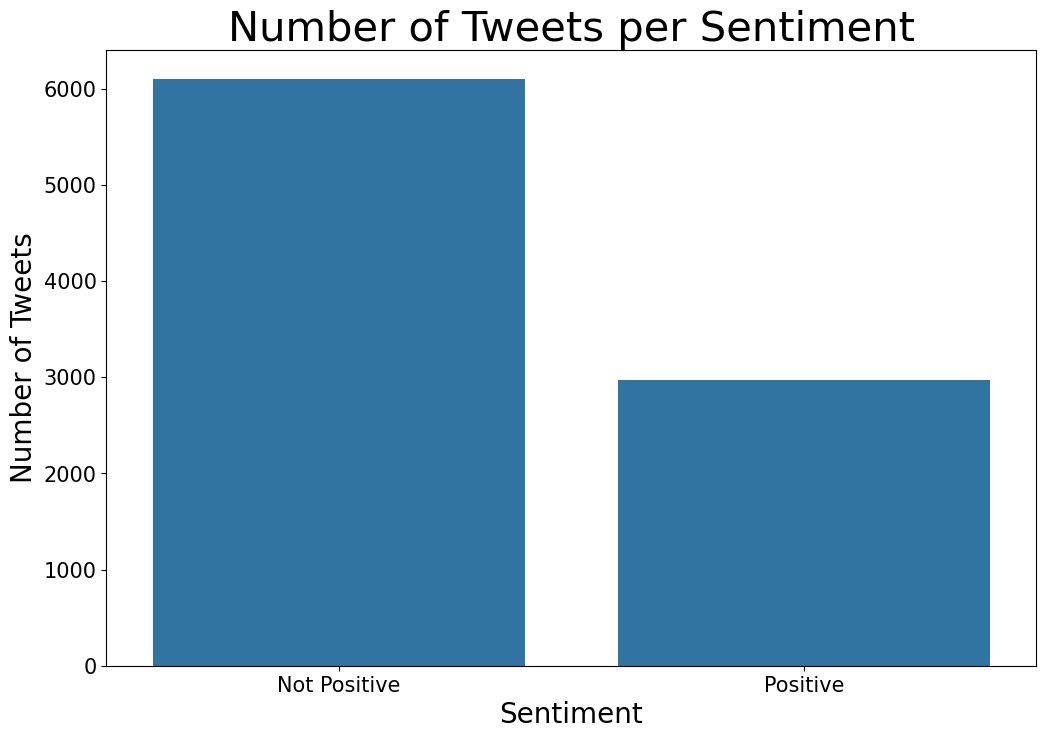

In [78]:
#Visualizing new Sentiment split
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(data = df, x = "Sentiment", order = df["Sentiment"].value_counts().index)
ax.set_xticklabels(labels = ["Not Positive", "Positive"], fontsize = 15)
ax.set_xlabel(xlabel = "Sentiment", fontsize = 20)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.set_ylabel(ylabel = "Number of Tweets", fontsize = 20)
ax.set_title(f"Number of Tweets per Sentiment", fontsize = 30)
plt.show()

In [82]:
#Create the X DataFrame with only the tweets
X = df[['Tweet']]
#Create the y Series with only the sentiments, 1 for Positive, 0 for not Positive
y = df['Sentiment']
#First train test split
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

#Second train test split
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=42)

In [83]:
#Check first few rows in X_train
X_train.head()

,Tweet
2320,@mention Can we make you an iPhone case with T...
5622,RT @mention Come party down with @mention &amp...
1748,#winning #winning - just gave away 5 red mophi...
5789,RT @mention google &amp; facebook have an offi...
3334,Rumor of Google launching their new social net...


In [84]:
#Check how many rows X_train has
X_train.shape

(6121, 1)

## Data Preprocessing

**Cleaning up the tweets:**

Remove:

* words with less than three characters
* stop words
* all forms of SXSW 
* "links' and 'video' since they are placeholders for links
* http//www websites and html formatting.
* panctuations and signs
* non-englis characters

Lowercase all words

Tokenize

Lemmatize

In [85]:
#Instantiate necessary tools
tokenizer = RegexpTokenizer(r"(?u)\w{3,}")
stopwords_list = stopwords.words("english")
stopwords_list.append("sxsw") #remove sxsw because it's the hashtag for the event
stopwords_list.append("link")
lemma = WordNetLemmatizer()
tweet_tknzr = TweetTokenizer(strip_handles=True)

In [86]:
def clean_tweets(text):
    """
    This function takes a tweet and preprocesses it for modeling
    """
    #Use TweetTokenizer object to remove the handles from the Tweet
    #TweetTokenizer also puts each punctuation as it's own token
    no_handle = tweet_tknzr.tokenize(text)
    #Join the list of non-handle tokens back together
    tweet = " ".join(no_handle) 
    #remove http websites, hashtag sign, any words in curly brackets,
        #any words with ampersand in front, www dot com websites, links,
        #videos, and non-english characters
    clean = re.sub("(https?:\/\/\S+) \
                   |(#[A-Za-z0-9_]+) \
                   |(\{([a-zA-Z].+)\}) \
                   |(&[a-z]+;) \
                   |(www\.[a-z]?\.?(com)+|[a-z]+\.(com))\
                   |({link})\
                   |(\[video\])\
                   |([^\x00-\x7F]+\ *(?:[^\x00-\x7F]| )*)"," ", tweet)
    #Turn all the tokens lowercase
    lower = clean.lower()
    #Only include words with 3 or more characters
    token_list = tokenizer.tokenize(lower)
    #Remove stopwords
    stopwords_removed=[token for token in token_list if token not in stopwords_list]
    #Lemmatize the remaining word tokens
    lemma_list = [lemma.lemmatize(token) for token in stopwords_removed]
    #Turn the lemma list into a string for the Vectorizer
    cleaned_string = " ".join(lemma_list) 
    return cleaned_string

<>:13: SyntaxWarning: invalid escape sequence '\/'
<>:13: SyntaxWarning: invalid escape sequence '\/'
C:\Users\ronoe\AppData\Local\Temp\ipykernel_712\1376136011.py:13: SyntaxWarning: invalid escape sequence '\/'
  clean = re.sub("(https?:\/\/\S+) \


In [90]:
#Sanity Check
clean_tweets(X_train['Tweet'].iloc[5622])

'new ubersocial iphone app store includes uberguide sponsored mashable'

In [89]:
#Apply our clean_tweets function to X_train, X_val
X_train['Tweet'] = X_train['Tweet'].apply(lambda x: clean_tweets(x))
X_val['Tweet'] = X_val['Tweet'].apply(lambda x: clean_tweets(x))

In [91]:
#Sanity Check
X_train

,Tweet
2320,make iphone case ttye time want show support
5622,come party google tonight band food art intera...
1748,winning winning gave away red mophie juice pac...
5789,google facebook official death policy vast maj...
3334,rumor google launching new social network call...
...,...
5692,even security guard austin enjoy ipad time
8582,attending want explore austin check austin via
7815,apple popup store gonnagetanipad
7483,putting pop apple store smart talk understandi...


In [92]:
y_train

2320    0
5622    1
1748    0
5789    0
3334    0
       ..
5692    1
8582    0
7815    0
7483    1
3531    0
Name: Sentiment, Length: 6121, dtype: int64

In [93]:
X_val

,Tweet
888,hootsuite mobile update iphone blackberry andr...
4191,morning hearing google circle today
2161,great location choice nice timing ipad launch ...
1882,win ipad via
4693,launching product plenty else join h4ckers dan...
...,...
1030,racing around best fueling great local fare ea...
4179,omg still line new ipad dieing hunger else line
7714,hour popup apple store lone security guard enj...
8190,great app interface example moma target flipbo...


In [94]:
y_val

888     0
4191    0
2161    1
1882    1
4693    0
       ..
1030    0
4179    1
7714    0
8190    1
4510    0
Name: Sentiment, Length: 2041, dtype: int64